In [1]:
#!/usr/bin/env python
# coding: utf-8

## Librerias

In [2]:
from pyGCS_ import *
import numpy as np
import numpy.ma as ma
import datetime
import struct
import os
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from scipy.stats import kde
from astropy.io import fits #proporciona acceso a los archivos de FITS(Flexible Image Transport System) es un estándar de archivos portátiles 
import sunpy
from sunpy.coordinates.ephemeris import get_horizons_coord
import sunpy.map
from sunpy.map.maputils import all_coordinates_from_map
import json
import random
import pandas as pd

## Función ajuste del centro del sol

In [3]:
def center_rSun_pixel(headers,plotranges, sat):
    x_cS = (headers[sat]['CRPIX1']*plotranges[sat][sat]*2)/headers[sat]['NAXIS1'] - plotranges[sat][sat]
    y_cS = (headers[sat]['CRPIX2']*plotranges[sat][sat]*2)/headers[sat]['NAXIS2'] - plotranges[sat][sat]
    return x_cS, y_cS

## Función Kernel Density Estimation (se parece a la de intensidad, pero no)

In [4]:
def xi_yi_zi_KDE(x, y, nbins=300): 
    
    #representa cada punto discreto por una campana de Gauss:
    k = kde.gaussian_kde([x,y]) 
    #nbins es el ancho de cada campana
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j] 
    zi = k(np.vstack([xi.flatten(), yi.flatten()])) 
    return  xi, yi, zi             
     

## Headers de CMEs reales, solo para usar la posición de los satélites

In [5]:
#flag if using LASCO data from ISSI which has STEREOlike headers already
ISSIflag = False

Read in your data

In [6]:
DATA_PATH = '/gehme/data'
secchipath = DATA_PATH+'/stereo/secchi/L0'
lascopath = DATA_PATH+'/soho/lasco/level_1/c2'

CorA = secchipath+'/a/img/cor2/20101214/level1/20101214_162400_04c2A.fts'
CorB = secchipath+'/b/img/cor2/20101214/level1/20101214_162400_04c2B.fts'
LascoC2 = lascopath+'/20101214/25354684.fts'

# STEREO A

In [7]:
ima2, hdra2 = sunpy.io.fits.read(CorA)[0]
smap_SA2 = sunpy.map.Map(ima2, hdra2)

# STEREO B

In [8]:
imb2, hdrb2 = sunpy.io.fits.read(CorB)[0]
smap_SB2 = sunpy.map.Map(imb2, hdrb2)

# LASCO

In [9]:
if ISSIflag:
    
#     imL1, hdrL1 = sunpy.io.fits.read(fnameL1)[0]
    imL2, hdrL2 = sunpy.io.fits.read(LascoC2)[0]
    
else:
#     with fits.open(fnameL1) as myfitsL1:
#         imL1 = myfitsL1[0].data
#         myfitsL1[0].header['OBSRVTRY'] = 'SOHO'
#         coordL1 = get_horizons_coord(-21, datetime.datetime.strptime(myfitsL1[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S.%f"), 'id')
#         coordL1carr = coordL1.transform_to(sunpy.coordinates.frames.HeliographicCarrington)
#         coordL1ston = coordL1.transform_to(sunpy.coordinates.frames.HeliographicStonyhurst)
#         myfitsL1[0].header['CRLT_OBS'] = coordL1carr.lat.deg
#         myfitsL1[0].header['CRLN_OBS'] = coordL1carr.lon.deg
#         myfitsL1[0].header['HGLT_OBS'] = coordL1ston.lat.deg
#         myfitsL1[0].header['HGLN_OBS'] = coordL1ston.lon.deg
#         hdrL1 = myfitsL1[0].header
    with fits.open(LascoC2) as myfitsL2:
        imL2 = myfitsL2[0].data
        myfitsL2[0].header['OBSRVTRY'] = 'SOHO'
        coordL2 = get_horizons_coord(-21, datetime.datetime.strptime(myfitsL2[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S.%f"), 'id')
        coordL2carr = coordL2.transform_to(sunpy.coordinates.frames.HeliographicCarrington)
        coordL2ston = coordL2.transform_to(sunpy.coordinates.frames.HeliographicStonyhurst)
        myfitsL2[0].header['CRLT_OBS'] = coordL2carr.lat.deg
        myfitsL2[0].header['CRLN_OBS'] = coordL2carr.lon.deg
        myfitsL2[0].header['HGLT_OBS'] = coordL2ston.lat.deg
        myfitsL2[0].header['HGLN_OBS'] = coordL2ston.lon.deg
        hdrL2 = myfitsL2[0].header
#smap_L1 = sunpy.map.Map(imL1, hdrL1)
#smap_L2 = sunpy.map.Map(imL2, hdrL2)

INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


In [10]:
headers = [hdra2, hdrL2, hdrb2]

#sin lasco:
#headers = [hdra2, hdrb2]

## Tamaño de los occulters referenciados al RSUN

In [11]:
cor2 = 2
c3 = 3.7

# DATOS DE ENTRADA

In [12]:
#arrays aleatorias de parámetros 1D:
n = 3 #cant de valores de cada parámetro

CMElons = np.random.randint(60, 63, n)

CMElats = np.random.randint(20, 23, n)

CMEtilts = np.random.randint(70, 73, n)

heights = np.random.randint(6, 9, n)

ks = np.random.random_sample(size = n)

angs = np.random.randint(30, 33, n)

#cada array de parámetro pasa a ser una columna del set de parámetros:

set_parameters = np.column_stack((CMElons, CMElats, CMEtilts, heights, ks, angs))

## Save configuración en .CSV

In [14]:
path = '/gehme/projects/2020_gcs_with_ml/data/forwardGCS_test/'
date_str = datetime.datetime.strftime(datetime.datetime.now(), '%Y%m%d_')
configfile_name = path+date_str+'Set_Parameters.csv'
header_name = [ 'CMElon',
           'CMElat',
           'CMEtilt',
           'height',
           'k',
           'ang'
           ]
set = pd.DataFrame(set_parameters, columns=header_name)
set.to_csv(configfile_name)

## Función forwardGCS, simula CMEs en 3D de distintos parámetros morfológicos pero desde la misma posición de los satélites, esta dada por los headers

In [15]:
def forwardGCS(configfile_name, headers, size_occ=[2,3.7,2]):
    # Get the location of sats and the range of each image:
    satpos, plotranges = processHeaders(headers)
    df = pd.DataFrame(pd.read_csv(configfile_name))
    for row in range(len(df)):
        clouds = getGCS(df['CMElon'][row], df['CMElat'][row], df['CMEtilt'][row], df['height'][row], df['k'][row], df['ang'][row], satpos)
        for sat in range(len(satpos)):
            #creo figura:
            fig = plt.figure(figsize=(3.556,3.556), facecolor='black')
            ax = fig.add_subplot()
            x = clouds[sat,:,1]
            y = clouds[0,:,2]
            #calculo el centro y el radio del sol en coordenada de plotrange
            x_cS, y_cS= center_rSun_pixel(headers,plotranges, sat)
            #mapeo la matriz [zi,xi], con límites [xi,yi]:
            #xi, yi, zi = xi_yi_zi_KDE(x, y)
            #plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='gist_yarg', facecolor='black')
            #plt.imshow(ims[sat], vmin=-10, vmax=10, cmap=cm.binary, zorder=0, extent=plotranges[sat])
            #imagen de puntos de la CME:
            plt.scatter(clouds[sat,:,1], clouds[0,:,2], s=5, c='purple', linewidths=0)
            #circulos occulter y limbo:
            occulter = plt.Circle((x_cS, y_cS), size_occ[sat], fc='white')
            limbo = plt.Circle((x_cS, y_cS), 1, ec='black', fc='white')
            #ax.add_artist(occulter)
            #ax.add_artist(limbo)
            #tamaño de la imagen referenciado al tamaño de la imagen del sol:
            plt.xlim(plotranges[sat][0],plotranges[sat][1])
            plt.ylim(plotranges[sat][2],plotranges[sat][3])
            plt.axis('off')
            #guardo cada vista CME
            
            fig.savefig('/gehme/projects/2020_gcs_with_ml/data/forwardGCS_test/{:08.3f}_{:08.3f}_{:08.3f}_{:08.3f}_{:08.3f}_{:08.3f}_sat{}.png'.format(df['CMElon'][row], df['CMElat'][row], df['CMEtilt'][row], df['height'][row], df['k'][row], df['ang'][row], sat+1),facecolor=fig.get_facecolor())
            
            plt.show()
            plt.close(fig)

## Prueba

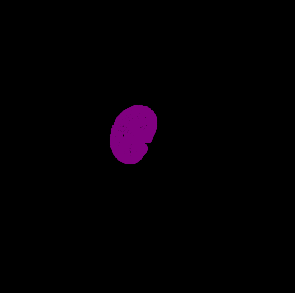

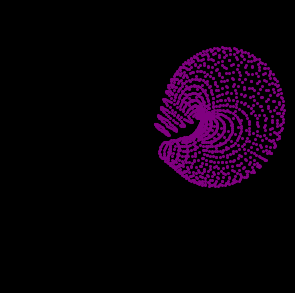

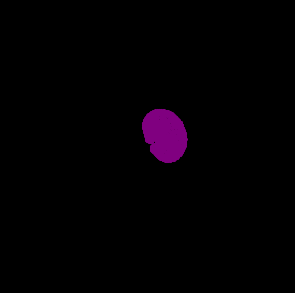

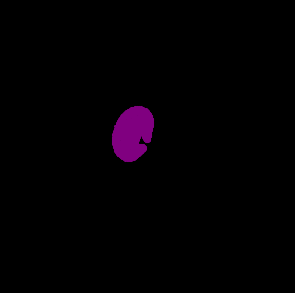

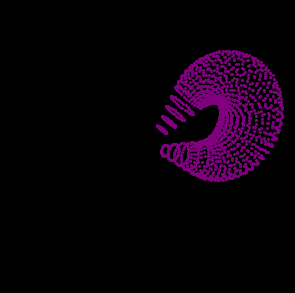

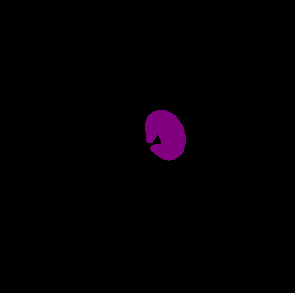

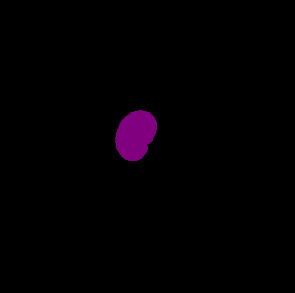

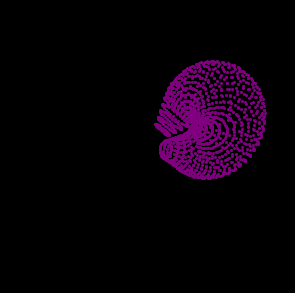

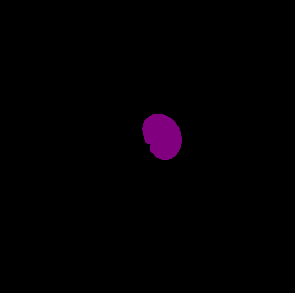

In [16]:
forwardGCS(configfile_name, headers)
